In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from deepymod.analysis import load_tensorboard
from natsort import natsorted
import os
import pandas as pd

In [2]:
# settings
plt.style.use('seaborn-paper')
col_width = 5.5 # neurips style column width in inches
fontsize=10
plt.rcParams.update({'font.size': fontsize})

# Single run plot

In [3]:
# loading data
df_bayes = load_tensorboard("runs_single/bayes_run_0/")
df_pinn = load_tensorboard("runs_single/pinn_run_0/")
df_mt = load_tensorboard("runs_single/multitask_run_0/")

AttributeError: 'DataFrame' object has no attribute 'loss'

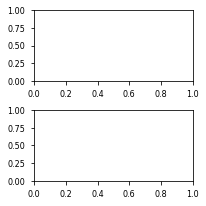

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(0.5 * col_width, 0.5 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(df_pinn.index, df_pinn.loss, label='PINN')
ax.plot(df_mt.index, df_mt.reg + df_mt.mse, label='MT')
ax.plot(df_bayes.index, df_bayes.reg + df_bayes.mse, label='BMT')

ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend()
#ax.set_xlabel('Epoch')
#ax.set_ylabel('Loss')
#ax.set_xticks([])
ax.set_yscale('log')
ax.set_xlim([0, 2500])
ax.set_ylim([5e-4, 3e-1])

ax = axes[1]
ax.plot(df_mt.index, df_mt.tau, label=r'$\tau_{MT}$')
ax.plot(df_mt.index, df_mt.nu, label=r'$\beta_{MT}$')

ax.plot(df_bayes.index, df_bayes.tau, label=r'$\tau_{BMT}$', linestyle='--')
ax.plot(df_bayes.index, df_bayes.nu, label=r'$\beta_{BMT}$', linestyle='--')


ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
#ax.set_ylabel('Precision')
ax.set_yscale('log')
ax.set_xlim([0, 2500])

plt.savefig('multitask.pdf', bbox_inches='tight')

# Multple run plot

In [3]:
files = natsorted([file for file in os.listdir('runs') if file.find('bayes')==0])
dfs_bayes = [load_tensorboard(f'runs/{file}') for file in files]

In [4]:
files = natsorted([file for file in os.listdir('runs') if file.find('multitask')==0])
dfs_mt = [load_tensorboard(f'runs/{file}') for file in files]

In [8]:
files = natsorted([file for file in os.listdir('runs') if file.find('pinn')==0])
dfs_pinn = [load_tensorboard(f'runs/{file}') for file in files]

In [9]:
def mean_std(prop, df_list, log):
    """Returns mean and std and (mean - std, mean + std) of prop for all dataframes in df_list."""
    data = np.stack([prop(df) for df in df_list], axis=1)
    if log:
        data = np.log10(data)
    mean = np.mean(data, axis=1)  
    std = np.std(data, axis=1)  
    return mean, std, (mean-std, mean + std)

In [10]:
bayes_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_bayes, log=True)
mt_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_mt, log=True)
pinn_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_pinn, log=True)

In [11]:
x_vals = dfs_bayes[0].index

In [12]:
tau_bayes = mean_std(lambda df: df.tau, dfs_bayes, log=True)
tau_mt = mean_std(lambda df: df.tau, dfs_mt, log=True)

beta_bayes = mean_std(lambda df: df.nu, dfs_bayes, log=True)
beta_mt = mean_std(lambda df: df.nu, dfs_mt, log=True)

In [13]:
fontsize = 8
plt.rcParams.update({'font.size': fontsize})

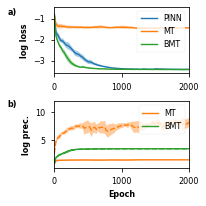

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(0.5 * col_width, 0.5 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(x_vals, pinn_mu_std[0], label="PINN")
ax.fill_between(x_vals, pinn_mu_std[2][0], pinn_mu_std[2][1], alpha=0.4)
ax.plot(x_vals, mt_mu_std[0], label='MT')
ax.fill_between(x_vals, mt_mu_std[2][0], mt_mu_std[2][1], alpha=0.4)

ax.plot(x_vals, bayes_mu_std[0], label='BMT')
ax.fill_between(x_vals, bayes_mu_std[2][0], bayes_mu_std[2][1], alpha=0.4)

ax.legend(loc='upper right')
ax.set_ylabel('log loss', fontdict={'weight':'bold', "size": fontsize})
ax.set_xlim([0, 2000])
ax.set_xticks([0, 1000, 2000])
ax.text(-700.0, -0.8, 'a)',fontdict={'weight':'bold', 'size': fontsize})


ax = axes[1]
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(x_vals, tau_mt[0], label='MT', color=color)
ax.fill_between(x_vals, tau_mt[2][0], tau_mt[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_mt[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_mt[2][0], beta_mt[2][1], alpha=0.4, color=color)

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(x_vals, tau_bayes[0], label='BMT', color=color)
ax.fill_between(x_vals, tau_bayes[2][0], tau_bayes[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_bayes[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_bayes[2][0], beta_bayes[2][1], alpha=0.4, color=color)

ax.text(-700.0, 11, 'b)', fontdict={'weight':'bold', 'size': fontsize})
ax.legend(loc='upper right')
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})
ax.set_ylabel('log prec.',  fontdict={'weight':'bold', "size":fontsize })
ax.set_xticks([0, 1000, 2000])
ax.set_xlim([0, 2000])

plt.savefig('multitask.pdf', bbox_inches='tight', pad_inches=0)